<h1 align="center">Long Stort-Term Memory (LSTM) for Sine Function Value Prediction</h1>

<hr>
<h3>Sine Function Values (Using from 0 to 2*Pi, Sequential Data)</h3>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Sine.svg/1200px-Sine.svg.png" width="500">
<pre>
上圖取自
<a href="https://zh.wikipedia.org/wiki/File:Sine.svg">https://zh.wikipedia.org/wiki/File:Sine.svg</a>
</pre>
<pre>
每次輸入一個 Sine 的數值（<span style="color:red">input_size=1</span>）
連續輸入五個數值（<span style="color:red">seq_len=5</span>）
預測下一個數值（<span style="color:red">output_size=1</span>）
</pre>

<hr>
<h3>Training Samples of Sine Function</h3>

In [1]:
# Training Samples of Sine Function

import numpy as np

# 樣本點（含 end points 為 n+1）
n = 100
# 預測輸入長度 seq_len
seq_len = 5
# 總訓練樣本數 n-seq_len+1
batch = n - seq_len + 1

sn = seq_len

q = np.arange(0, 2*np.pi+0.000001, 2*np.pi/n)
s = np.sin(q)

# print(q)
# print(s)

# print('Sine function:')
# for i in range(len(q)):
#     t = '%3d:%12.8f,%12.8f' % (i, q[i], s[i])
#     print(t)
# print()

x_np = np.zeros([n-sn+1,sn], dtype=np.float32)
y_np = np.zeros([n-sn+1], dtype=np.float32)

print('Training samples of sine function:')
for i in range(n-sn+1):
    print('%3d: input = '%(i), end='')
    for d in range(sn):
        x_np[i,d] = s[i+d]
        print('%12.8f'%(x_np[i,d]), end='')
    y_np[i] = s[i+d+1]
    print(', outout = %12.8f'%(y_np[i]))
print()


Training samples of sine function:
  0: input =   0.00000000  0.06279052  0.12533323  0.18738131  0.24868989, outout =   0.30901700
  1: input =   0.06279052  0.12533323  0.18738131  0.24868989  0.30901700, outout =   0.36812454
  2: input =   0.12533323  0.18738131  0.24868989  0.30901700  0.36812454, outout =   0.42577928
  3: input =   0.18738131  0.24868989  0.30901700  0.36812454  0.42577928, outout =   0.48175368
  4: input =   0.24868989  0.30901700  0.36812454  0.42577928  0.48175368, outout =   0.53582680
  5: input =   0.30901700  0.36812454  0.42577928  0.48175368  0.53582680, outout =   0.58778524
  6: input =   0.36812454  0.42577928  0.48175368  0.53582680  0.58778524, outout =   0.63742399
  7: input =   0.42577928  0.48175368  0.53582680  0.58778524  0.63742399, outout =   0.68454713
  8: input =   0.48175368  0.53582680  0.58778524  0.63742399  0.68454713, outout =   0.72896862
  9: input =   0.53582680  0.58778524  0.63742399  0.68454713  0.72896862, outout =   0.7705

<hr>
<h3>轉換為 RNN/LSTM 所需 PyTorch Tensor 格式</h3>
<pre>
total sequence length = 96 (0...95)
input_tensor shape = (batch, seq_len, input_size)
batch = 96
seq_len = 5
input_size = 1 (dim of input feature vector)
</pre>

In [2]:
# 轉換為 RNN/LSTM 所需 PyTorch Tensor 格式

import torch

print(x_np.shape)
print(y_np.shape)

input_size = 1
output_size = 1

xx_np = x_np.reshape([batch,seq_len,input_size])
yy_np = y_np.reshape([batch,output_size])

print(xx_np.shape)
print(yy_np.shape)

x = torch.from_numpy(xx_np)
y = torch.from_numpy(yy_np)

print(x.shape)
print(y.shape)


(96, 5)
(96,)
(96, 5, 1)
(96, 1)
torch.Size([96, 5, 1])
torch.Size([96, 1])


<hr>
<h3>Simple-RNN / LSTM Parameters</h3>

In [3]:
input_size = 1 # 輸入特徵數目
batch = len(x) # 訓練樣本數（96）
seq_len = 5 # 連續送幾個信號後輸出預測
hidden_size = 8 # 隱藏層細胞數
num_layers = 1 # 隱藏層層數
output_size = 1 # 輸出數值數目

<hr>
<h3>定義與建立 Simple RNN 模型</h3>
<p style="color:red">batch_first=True</p>

In [4]:
# 定義與建立 Simple RNN 模型

import torch
import torch.nn as nn

class MyRNN(nn.Module):
    def __init__(self, input_size):
        super(MyRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )
        self.h0 = torch.randn(num_layers, batch, hidden_size)
    def forward(self, x):
        h_out, hn = self.rnn(x, self.h0)
        out = self.fc(h_out)
        return out

rnn = MyRNN(input_size)
print(rnn)

# params = list(rnn.parameters())
# print(params)


MyRNN(
  (rnn): RNN(1, 8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


<hr>
<h3>Simple RNN Training</h3>

In [5]:
# Simple RNN Training

# Loss function
loss_func = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

EPOCH = 10000

for epoch in range(EPOCH):
    optimizer.zero_grad()
    # shuffling
    permute = torch.randperm(x.size()[0])
    xi = x[permute]
    yi = y[permute]
    # feed forward
    output = rnn(xi)
    # print(output[:,-1,:].shape)
    # print(yi.shape)
    # evaluating loss
    loss = loss_func(output[:,-1,:], yi)
    # display loss
    if (epoch % 100 == 0):
        print('epoch = %5d, loss = %16.12f' % (epoch, loss.item()))
    # feed backward
    loss.backward()
    # update parameters
    optimizer.step()

torch.save(rnn.state_dict(), 'rnn_sine.model')


epoch =     0, loss =   0.678403079510
epoch =   100, loss =   0.327461719513
epoch =   200, loss =   0.021240418777
epoch =   300, loss =   0.013796861283
epoch =   400, loss =   0.012150521390
epoch =   500, loss =   0.010130823590
epoch =   600, loss =   0.009241026826
epoch =   700, loss =   0.007492339704
epoch =   800, loss =   0.007020989899
epoch =   900, loss =   0.005271953065
epoch =  1000, loss =   0.004832277074
epoch =  1100, loss =   0.004120472353
epoch =  1200, loss =   0.004206020851
epoch =  1300, loss =   0.003672800725
epoch =  1400, loss =   0.002954785945
epoch =  1500, loss =   0.002486465266
epoch =  1600, loss =   0.002455123002
epoch =  1700, loss =   0.002065049717
epoch =  1800, loss =   0.001894148882
epoch =  1900, loss =   0.002012608107
epoch =  2000, loss =   0.001889612991
epoch =  2100, loss =   0.001876625232
epoch =  2200, loss =   0.001324068638
epoch =  2300, loss =   0.001290655229
epoch =  2400, loss =   0.001123634633
epoch =  2500, loss =   0

<hr>
<h3>定義與建立 LSTM 模型</h3>
<p style="color:red">batch_first=True</p>

In [6]:
# 定義與建立 LSTM 模型

import torch
import torch.nn as nn

class MyLSTM(nn.Module):
    def __init__(self, input_size):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )
        self.h0 = torch.randn(num_layers, batch, hidden_size)
        self.c0 = torch.randn(num_layers, batch, hidden_size)
    def forward(self, x):
        h_out, (hn,cn) = self.lstm(x, (self.h0,self.c0))
        out = self.fc(h_out)
        return out

lstm = MyLSTM(input_size)
print(lstm)

# params = list(lstm.parameters())
# print(params)


MyLSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


<hr>
<h3>LSTM Training</h3>

In [7]:
# LSTM Training

# Loss function
loss_func = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

EPOCH = 10000

for epoch in range(EPOCH):
    optimizer.zero_grad()
    # shuffling
    permute = torch.randperm(x.size()[0])
    xi = x[permute]
    yi = y[permute]
    # feed forward
    output = lstm(xi)
    # print(output[:,-1,:].shape)
    # print(yi.shape)
    # evaluating loss
    loss = loss_func(output[:,-1,:], yi)
    # display loss
    if (epoch % 100 == 0):
        print('epoch = %5d, loss = %16.12f' % (epoch, loss.item()))
    # feed backward
    loss.backward()
    # update parameters
    optimizer.step()

torch.save(lstm.state_dict(), 'lstm_sine.model')


epoch =     0, loss =   0.532831192017
epoch =   100, loss =   0.187320783734
epoch =   200, loss =   0.031739644706
epoch =   300, loss =   0.018320083618
epoch =   400, loss =   0.012233854271
epoch =   500, loss =   0.009417828172
epoch =   600, loss =   0.008047939278
epoch =   700, loss =   0.006489146966
epoch =   800, loss =   0.005175956059
epoch =   900, loss =   0.004128130618
epoch =  1000, loss =   0.003563909791
epoch =  1100, loss =   0.003040527226
epoch =  1200, loss =   0.002638384700
epoch =  1300, loss =   0.002117326250
epoch =  1400, loss =   0.001662229653
epoch =  1500, loss =   0.001566611347
epoch =  1600, loss =   0.001213571639
epoch =  1700, loss =   0.001152855461
epoch =  1800, loss =   0.000979959732
epoch =  1900, loss =   0.000886124268
epoch =  2000, loss =   0.000615511672
epoch =  2100, loss =   0.000598279003
epoch =  2200, loss =   0.000518616813
epoch =  2300, loss =   0.000418530894
epoch =  2400, loss =   0.000413528760
epoch =  2500, loss =   0

<hr>
<h3>整批預測</h3>

In [8]:
# 整批預測

import numpy as np

py = y[:,0].tolist()

output = lstm(x)

lst = output[:,-1,:].detach().tolist()
pt = [ p[0] for p in lst ]

# print(py)
# print(pt)

mse = 0
for i in range(len(py)):
    mse = mse + (pt[i]-py[i])**2
print('mse = ', mse)


mse =  0.0004069512018346986


<hr>
<h3>Initiate matplotlib</h3>

In [9]:
# matplotlib 第一張圖常常不能顯示，所以先產生一張，當作啟動，讓後續真正需要的圖表能正常顯示
import matplotlib
import matplotlib.pyplot as plt
plt.show()

<hr>
<h3>視覺化驗證</h3>
<pre>
綠色：理論值
紅色：預測值
</pre>
<p>（幾乎重合，完美預測）</p>

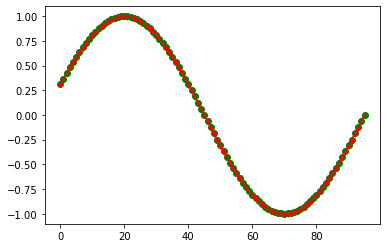

In [10]:
# 視覺化驗證

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(py, color='green', marker='o')
plt.plot(pt, color='red', marker='+')

# plt.xlim([0, len(py)])
# plt.ylim([-1.5, 1.5])

plt.show()


<hr>
<h3>將原本全部訓練樣本分為訓練樣本與測試樣本</h3>
<pre>
x (96) --> x_train (48) + x_test (48)
y (96) --> y_train (48) + y_test (48)
</pre>

In [11]:
import torch

half = len(x)//2

x_train = torch.zeros([half, x.shape[1], x.shape[2]])
x_test  = torch.zeros([half, x.shape[1], x.shape[2]])
y_train = torch.zeros([half, y.shape[1]])
y_test  = torch.zeros([half, y.shape[1]])

print(half)
print(x.shape, x_train.shape, x_test.shape)
print(y.shape, y_train.shape, y_test.shape)
                       
for i in range(half):
    x_train[i] = x[i*2]
    x_test[i]  = x[i*2+1]
    y_train[i] = y[i*2]
    y_test[i]  = y[i*2+1]


48
torch.Size([96, 5, 1]) torch.Size([48, 5, 1]) torch.Size([48, 5, 1])
torch.Size([96, 1]) torch.Size([48, 1]) torch.Size([48, 1])


<hr>
<h3>重新訓練新 Simple RNN 模型</h3>

In [12]:
# 重新訓練新 Simple-RNN 模型

batch = half

class MyRNN(nn.Module):
    def __init__(self, input_size):
        super(MyRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )
        self.h0 = torch.randn(num_layers, batch, hidden_size)
    def forward(self, x):
        h_out, hn = self.rnn(x, self.h0)
        out = self.fc(h_out)
        return out

# 新 Simple-RNN 模型
rnn = MyRNN(input_size)

# Simple-RNN Training

# Loss function
loss_func = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

EPOCH = 10000

for epoch in range(EPOCH):
    optimizer.zero_grad()
    # shuffling
    permute = torch.randperm(x_train.size()[0])
    xi = x[permute]
    yi = y[permute]
    # feed forward
    output = rnn(xi)
    # print(output[:,-1,:].shape)
    # print(yi.shape)
    # evaluating loss
    loss = loss_func(output[:,-1,:], yi)
    # display loss
    if (epoch % 100 == 0):
        print('epoch = %5d, loss = %16.12f' % (epoch, loss.item()))
    # feed backward
    loss.backward()
    # update parameters
    optimizer.step()

torch.save(rnn.state_dict(), 'rnn_sine_new.model')


epoch =     0, loss =   0.732320725918
epoch =   100, loss =   0.090209722519
epoch =   200, loss =   0.037110000849
epoch =   300, loss =   0.014238398522
epoch =   400, loss =   0.010314273648
epoch =   500, loss =   0.008739180863
epoch =   600, loss =   0.007373479661
epoch =   700, loss =   0.005424050614
epoch =   800, loss =   0.005471128970
epoch =   900, loss =   0.004354117904
epoch =  1000, loss =   0.003625756130
epoch =  1100, loss =   0.003125532763
epoch =  1200, loss =   0.002325920621
epoch =  1300, loss =   0.001781874686
epoch =  1400, loss =   0.001259672688
epoch =  1500, loss =   0.001217463636
epoch =  1600, loss =   0.000907752954
epoch =  1700, loss =   0.000804704614
epoch =  1800, loss =   0.000593112374
epoch =  1900, loss =   0.000675391580
epoch =  2000, loss =   0.000388540444
epoch =  2100, loss =   0.000428247702
epoch =  2200, loss =   0.000362738589
epoch =  2300, loss =   0.000360489212
epoch =  2400, loss =   0.000363814062
epoch =  2500, loss =   0

<hr>
<h3>重新訓練新 LSTM 模型</h3>

In [13]:
# 重新訓練新 LSTM 模型

batch = half

class MyLSTM(nn.Module):
    def __init__(self, input_size):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1)
        )
        self.h0 = torch.randn(num_layers, batch, hidden_size)
        self.c0 = torch.randn(num_layers, batch, hidden_size)
    def forward(self, x):
        h_out, (hn,cn) = self.lstm(x, (self.h0,self.c0))
        out = self.fc(h_out)
        return out

# 新 LSTM 模型
lstm = MyLSTM(input_size)

# LSTM Training

# Loss function
loss_func = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

EPOCH = 10000

for epoch in range(EPOCH):
    optimizer.zero_grad()
    # shuffling
    permute = torch.randperm(x_train.size()[0])
    xi = x[permute]
    yi = y[permute]
    # feed forward
    output = lstm(xi)
    # print(output[:,-1,:].shape)
    # print(yi.shape)
    # evaluating loss
    loss = loss_func(output[:,-1,:], yi)
    # display loss
    if (epoch % 100 == 0):
        print('epoch = %5d, loss = %16.12f' % (epoch, loss.item()))
    # feed backward
    loss.backward()
    # update parameters
    optimizer.step()

torch.save(lstm.state_dict(), 'lstm_sine_new.model')


epoch =     0, loss =   1.161823034286
epoch =   100, loss =   0.411739617586
epoch =   200, loss =   0.062538124621
epoch =   300, loss =   0.050942033529
epoch =   400, loss =   0.034148223698
epoch =   500, loss =   0.024604899809
epoch =   600, loss =   0.015211053193
epoch =   700, loss =   0.011984605342
epoch =   800, loss =   0.009122331627
epoch =   900, loss =   0.009425191209
epoch =  1000, loss =   0.007949518971
epoch =  1100, loss =   0.007635464892
epoch =  1200, loss =   0.007092976943
epoch =  1300, loss =   0.005644928198
epoch =  1400, loss =   0.005346532911
epoch =  1500, loss =   0.004500878509
epoch =  1600, loss =   0.003780361498
epoch =  1700, loss =   0.002985656029
epoch =  1800, loss =   0.002612766810
epoch =  1900, loss =   0.002249595942
epoch =  2000, loss =   0.001891274122
epoch =  2100, loss =   0.001634326414
epoch =  2200, loss =   0.001105966978
epoch =  2300, loss =   0.001073456602
epoch =  2400, loss =   0.001010118867
epoch =  2500, loss =   0

<hr>
<h3>Simple-RNN 重新整批預測</h3>

mse =  0.018066762668783178


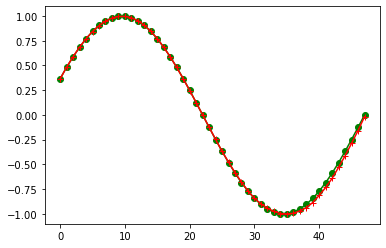

In [14]:
# 重新整批預測

import numpy as np

py = y_test[:,0].tolist()

output = rnn(x_test)

lst = output[:,-1,:].detach().tolist()
pt = [ p[0] for p in lst ]

# print(py)
# print(pt)

mse = 0
for i in range(len(py)):
    mse = mse + (pt[i]-py[i])**2
print('mse = ', mse)

# 視覺化驗證

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(py, color='green', marker='o')
plt.plot(pt, color='red', marker='+')

# plt.xlim([0, len(py)])
# plt.ylim([-1.5, 1.5])

plt.show()


<hr>
<h3>LSTM 重新整批預測</h3>

mse =  0.20040914538963436


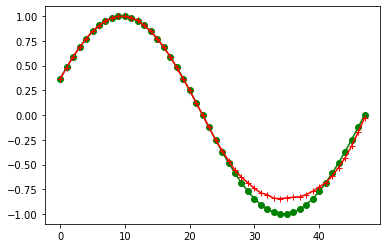

In [15]:
# 重新整批預測

import numpy as np

py = y_test[:,0].tolist()

output = lstm(x_test)

lst = output[:,-1,:].detach().tolist()
pt = [ p[0] for p in lst ]

# print(py)
# print(pt)

mse = 0
for i in range(len(py)):
    mse = mse + (pt[i]-py[i])**2
print('mse = ', mse)

# 視覺化驗證

import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(py, color='green', marker='o')
plt.plot(pt, color='red', marker='+')

# plt.xlim([0, len(py)])
# plt.ylim([-1.5, 1.5])

plt.show()
